# Inference with InstructBLIP

This notebook showcases inference with the [InstructBLIP](https://huggingface.co/docs/transformers/main/model_doc/instructblip) model by Salesforce. InstructBLIP is a vision-language instruction-tuned version of [BLIP-2](https://huggingface.co/docs/transformers/main/model_doc/blip-2), enabling chat conversations with the model about images. It's one of the best open-source multimodal AI models out there at the time of writing. It basically allows us to feed visual inputs (images) to a large language model (LLM).

The Salesforce authors released 4 checkpoints; 2 of which leverage Vicuna ([LLaMa](https://huggingface.co/docs/transformers/main/model_doc/llama)) as large language model, and 2 of which leverage [Flan-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5). They can be found [here](https://huggingface.co/models?other=instructblip).

As the amount of memory required for those models is pretty large, we'll leverage 4-bit/8-bit inference by [bitsandbytes](https://github.com/TimDettmers/bitsandbytes), which enables to roughly half the amount of memory required to load these models, while maintaining the same performance. Note that we need to be careful regarding this, as the Flan-T5 checkpoints for instance were pre-trained using bfloat16. You can find the tweet about this [here](https://twitter.com/NielsRogge/status/1676253871868395523).

## Set-up environment

For this demo we need the Hugging Face Transformers library, as well as Hugging Face Accelerate and bitsandbytes.

In [ ]:
# !pip install -q git+https://github.com/huggingface/transformers.git accelerate bitsandbytes

## Load the model (Vicuna, in low precision)

By default, each parameter of an AI model is typically stored using 32 bits, or 4 bytes. This means that for a model that has 8 billion parameters for instance, we would require 8 billion times 4 = 32 billion bytes, or in other words 32 GB of GPU memory. Moreover, you need twice the amount of disk space (as we first load the model with randomly initialized weights, then load the pre-trained ones). Luckily, the Accelerate library provides some nice tricks to handle big model inference efficiently. Read more about it [here](https://huggingface.co/docs/accelerate/usage_guides/big_modeling).

Below, we'll load the model that leverages a Vicuna-7b large language model in 4 bit-precision (or half a byte per parameter). This greatly reduces the amount of memory required to load the model. It uses a clever algorithm by bitsandbytes, a blog post about it can be found [here](https://huggingface.co/blog/4bit-transformers-bitsandbytes).

In [1]:
from transformers import InstructBlipProcessor, InstructBlipForConditionalGeneration
import torch

processor = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-vicuna-7b")
model = InstructBlipForConditionalGeneration.from_pretrained("Salesforce/instructblip-vicuna-7b", load_in_4bit=True, torch_dtype=torch.float16)

/home/niels/python_projects/transformers/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-06 19:57:43.822731: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/niels/python_projects/transformers/env/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda110.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 110
CUDA SETUP: Loading binary /home/niels/python_projects/transformers/env/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda110.so...


/home/niels/python_projects/transformers/env/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /home/niels/anaconda3 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/home/niels/python_projects/transformers/env/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/var/lib/nvidia-mig-manager/checkpoint.json')}
  warn(msg)
/home/niels/python_projects/transformers/env/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('vs/workbench/api/node/extensionHostProcess')}
  warn(msg)
/home/niels/python_projects/transformers/env/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in y

## Load image

Next, let's load an image which we'll use to chat about with the InstructBLIP model.

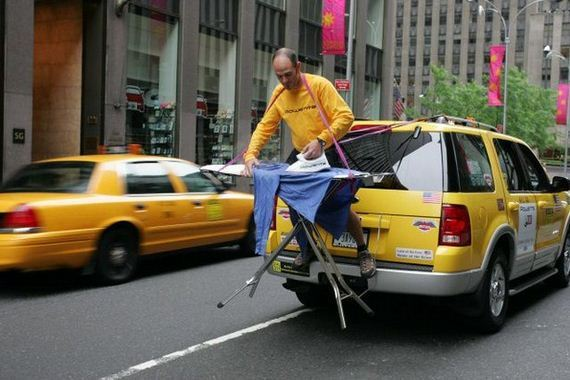

In [2]:
from PIL import Image
import requests

url = "https://raw.githubusercontent.com/salesforce/LAVIS/main/docs/_static/Confusing-Pictures.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
image

## Generate

Interacting with the model is as simple as calling the [generate()](https://huggingface.co/docs/transformers/v4.30.0/en/main_classes/text_generation#transformers.GenerationMixin.generate) method.

Below we use the same generation parameters as used in the original implementation, which is beam search with maximum 256 tokens.

In [3]:
# prepare image and prompt for the model
prompt = "What is unusual about this image?"
inputs = processor(images=image, text=prompt, return_tensors="pt").to(device="cuda", dtype=torch.float16)

# autoregressively generate an answer
outputs = model.generate(
        **inputs,
        num_beams=5,
        max_new_tokens=256,
        min_length=1,
        top_p=0.9,
        repetition_penalty=1.5,
        length_penalty=1.0,
        temperature=1,
)
outputs[outputs == 0] = 2 # this line can be removed once https://github.com/huggingface/transformers/pull/24492 is fixed
generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
print(generated_text)

The unusual aspect of this image is that a man is washing clothes on the back of a yellow SUV while driving down a busy city street. This is an unconventional way of doing laundry, as it requires the driver's attention and could potentially cause distractions while operating the vehicle. Additionally, the presence of a yellow taxi cab in the scene adds to the unexpectedness of the situation, as taxis are typically associated with urban transportation rather than laundry services.


We can ask a follow-up question as follows:

In [4]:
prompt = "In which city do you think this image is taken?"
inputs = processor(images=image, text=prompt, return_tensors="pt").to(device="cuda", dtype=torch.float16)

outputs = model.generate(
        **inputs,
        do_sample=False,
        num_beams=5,
        max_length=256,
        min_length=1,
        top_p=0.9,
        repetition_penalty=1.5,
        length_penalty=1.0,
        temperature=1,
)
outputs[outputs == 0] = 2 # this line can be removed once https://github.com/huggingface/transformers/pull/24492 is merged
generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
print(generated_text)

new york


## Load InstructBLIP with Flan-T5 models

For the models that leverage the [Flan-T5](https://huggingface.co/docs/transformers/model_doc/flan-t5) large language models, we need to be careful to keep the parameters in bfloat16 rather than float16, as bfloat16 is the dtype that Google used when pre-training Flan-T5. You cannot cast models trained using bfloat16 to float16 (would result in garbage outputs), but you can cast the other way around.

In [5]:
processor = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-flan-t5-xl")
model = InstructBlipForConditionalGeneration.from_pretrained("Salesforce/instructblip-flan-t5-xl", load_in_4bit=True, torch_dtype=torch.bfloat16)

Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.10s/it]


Similarly, when providing the inputs to the model, we need to cast them to bfloat16.

In [8]:
# prepare image and prompt for the model
prompt = "What is unusual about this image?"
inputs = processor(images=image, text=prompt, return_tensors="pt").to(device="cuda", dtype=torch.bfloat16)

# autoregressively generate an answer
outputs = model.generate(
        **inputs,
        num_beams=5,
        max_new_tokens=256,
        min_length=1,
        top_p=0.9,
        repetition_penalty=1.5,
        length_penalty=1.0,
        temperature=1,
)
generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
print(generated_text)

The image shows a man ironing clothes on the back of a yellow car in the middle of a busy city street. The man is wearing a yellow shirt with a bright yellow tie, suggesting that he is working in a laundry or dry-cleaning business. He is standing on the back of the car, which may suggest that he is doing his own laundry at home, rather than using a commercial laundry service. The image may also suggest that the man is trying to save money by doing his own laundry at home rather than using a commercial laundry service.


We can see that in this particular case, the vicuna-7b checkpoint seems to have a better understanding of the image compared to the Flan-T5 one.

However this is just one example, one would need to check on various images which model actually perfoms best. Let's try another one! Below we'll give it an image of itself (the architecture of InstructBLIP).

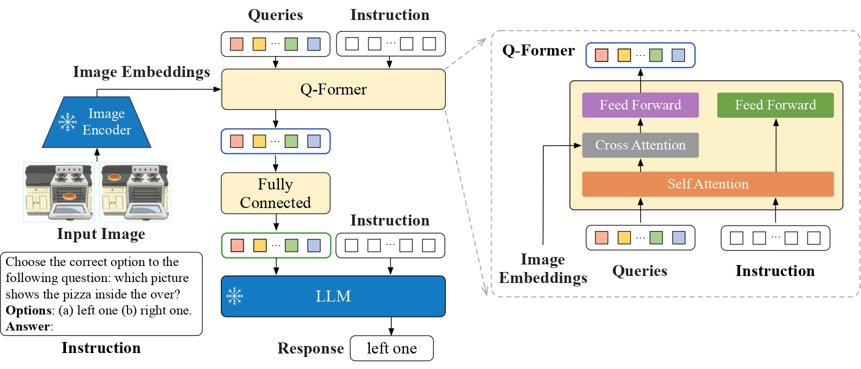

In [20]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/instructblip_architecture.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
width, height = image.size
new_image = image.resize((int(0.5*width), int(0.5*height)))
new_image

In [24]:
# prepare image and prompt for the model
prompt = "What does the image represent?"
inputs = processor(images=image, text=prompt, return_tensors="pt").to(device="cuda", dtype=torch.bfloat16)

# autoregressively generate an answer
outputs = model.generate(
        **inputs,
        num_beams=5,
        max_new_tokens=256,
        min_length=1,
        top_p=0.9,
        repetition_penalty=1.5,
        length_penalty=1.0,
        temperature=1,
)
generated_text = processor.batch_decode(outputs, skip_special_tokens=True)[0].strip()
print(generated_text)

The image represents a diagram of an image processing system.
